Fit Pacheco et al. data with linear & nonlinear models.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import hankel
from scipy import optimize, signal, stats
from sklearn.linear_model import LinearRegression
import sys

from disp import set_font_size

cc = np.concatenate

FPS = 2
DT = 1/FPS
NT = 61
T = DT*np.arange(NT) - 10

IT_STIM = (20, 40)
IDUR_STIM = IT_STIM[1] - IT_STIM[0]
DUR_STIM = DT*IDUR_STIM

T_COLS = [f'IT_{it}' for it in range(NT)]

IDUR_H = 20
H_T_COLS = [f'IT_H_S_{it}' for it in range(IDUR_H)] + [f'IT_H_P_{it}' for it in range(IDUR_H)]

LOAD_FILE = 'data/simple/pacheco.csv'

In [2]:
# load data
df = pd.read_csv(LOAD_FILE)
df

EXPT_ID STIM  FLY NEUROPIL  NEUROPIL_IDX  RESPONSE_TYPE_LABEL  \
0            0    S    1    sSADC             0                   13   
1            0    P    1    sSADC             0                   13   
2            1    S    1     AMMC             1                   13   
3            1    P    1     AMMC             1                   13   
4            2    S    1    sSADC             0                   13   
...        ...  ...  ...      ...           ...                  ...   
38067    19033    P   47      GNG             3                   18   
38068    19034    S   47    sSADC             0                   15   
38069    19034    P   47    sSADC             0                   15   
38070    19035    S   47      PLP             7                   12   
38071    19035    P   47      PLP             7                   12   

           IT_0      IT_1      IT_2      IT_3  ...     IT_51     IT_52  \
0     -0.033654  0.039349 -0.090484  0.401704  ...  1.082081  0.920516   
1      0.617594  0.378234  0.414807  0.080734  ...  0.246901  0.488439   
2      0.336833  0.408993  0.474425  0.213802  ...  1.001931  0.897849   
3      0.168264 -0.182815 -0.143902  0.101796  ...  0.702984  0.584333   
4      0.261517  0.033362  0.034890  0.212583  ...  0.288560  0.482021   
...         ...       ...       ...       ...  ...       ...       ...   
38067 -0.039356 -0.014598 -0.034997 -0.035381  ...  0.153143  0.171215   
38068  0.710741  0.594676  0.427717  0.166460  ...  2.247301  1.373531   
38069  0.662882  0.455962  0.019223 -0.011819  ...  1.422577  1.974313   
38070  0.123877 -0.103292 -0.265331 -0.061722  ...  0.086945  0.273224   
38071  0.224790  0.146400  0.564373  0.667887  ...  1.329415  0.848046   

          IT_53     IT_54     IT_55     IT_56     IT_57     IT_58     IT_59  \
0      0.633192  0.459923  0.777835  0.852022  0.777709  0.278367  0.074631   
1      0.480255  0.425880  0.650568  0.628899  0.368041  0.032336  0.248447   
2      0.874968  0.410459  0.555852  0.387268  0.438035  0.307526  0.391527   
3      0.336659  0.414276  0.284469  0.080918  0.384536  0.325093  0.335583   
4      0.431282  0.281125  0.085184 -0.035244  0.125191  0.065407 -0.110486   
...         ...       ...       ...       ...       ...       ...       ...   
38067  0.112855  0.084740  0.064839  0.034636  0.019822  0.042430  0.048326   
38068  1.862249  1.769727  1.958070  2.003307  1.319867  1.124926  1.354274   
38069  1.708528  1.429057  1.396340  1.190694  0.925789  0.586538  0.335784   
38070  0.522694  0.491431  0.948518  1.173859  1.000480  0.539625  0.273782   
38071  0.354544  0.316999  0.423245  0.641923  0.651434  0.337984  0.315271   

          IT_60  
0      0.042462  
1     -0.126652  
2      0.531009  
3      0.242322  
4     -0.020802  
...         ...  
38067  0.051901  
38068  1.268899  
38069  0.296388  
38070 -0.010819  
38071  0.296231  

[38072 rows x 67 columns]

Fit linear filters

In [3]:
# smln function
def smlt(h_s, h_p, t_0, inp):
    """Simulate response to sine or pulse inputs."""
    stim = np.zeros(NT)
    stim[(t_0 <= T) & (T < t_0 + DUR_STIM)] = 1

    if inp == 's':
        r = signal.fftconvolve(stim, h_s, mode='full')[:NT]*DT
    elif inp == 'p':
        r = signal.fftconvolve(stim, h_p, mode='full')[:NT]*DT
    
    return r


def make_dsn_mat(x, nbak):
    return hankel(cc([np.zeros(nbak-1), x]))[:len(x), :nbak]

In [4]:
# loop over expt_ids
expt_ids = np.sort(np.unique(df['EXPT_ID']))

cols_pred_lin = df.columns
data_pred_lin = []

cols_param_lin = ['EXPT_ID', 'FLY', 'NEUROPIL', 'NEUROPIL_IDX', 'RESPONSE_TYPE_LABEL', 'FIT_ERR', 'SUCCESS', 'IDUR_H'] + ['T_0', 'R_0'] + [f'IT_H_S_{it}' for it in range(IDUR_H)] + [f'IT_H_P_{it}' for it in range(IDUR_H)]
data_param_lin = []

for expt_id in expt_ids:
    sys.stdout.write('.')
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    fly = row_s['FLY']
    neuropil = row_s['NEUROPIL']
    neuropil_idx = row_s['NEUROPIL_IDX']
    response_type_label = row_s['RESPONSE_TYPE_LABEL']
    
    r_s = np.array(row_s[T_COLS]).astype(float)
    r_p = np.array(row_p[T_COLS]).astype(float)
    
    mvalid_s = ~np.isnan(r_s)
    mvalid_p = ~np.isnan(r_p)
    
    # fit model
    t_0s = -DT*np.arange(-2, 9)
    sq_err_best = np.inf
    for t_0 in t_0s:
        stim = np.zeros(NT)
        stim[(t_0 <= T) * (T < t_0 + DUR_STIM)] = 1
        
        # build stim design matrix
        stim_mat = make_dsn_mat(stim, IDUR_H)
        
        # get sine filter
        h_s = LinearRegression().fit(stim_mat[mvalid_s, :], r_s[mvalid_s]/DT).coef_[::-1]
        h_p = LinearRegression().fit(stim_mat[mvalid_p, :], r_p[mvalid_p]/DT).coef_[::-1]
        
        sq_err = .5*np.nanmean((r_s-smlt(h_s, h_p, t_0, 's'))**2) + .5*np.nanmean((r_p-smlt(h_s, h_p, t_0, 'p'))**2)
        if sq_err < sq_err_best:
            sq_err_best = sq_err
            t_0_best = t_0
            h_s_best = h_s
            h_p_best = h_p
        
    t_0 = t_0_best
    
    # unpack params
    r_0 = 0
    h_s = h_s_best.copy()
    h_p = h_p_best.copy()
    
    # make predictions
    stim = np.zeros(NT)
    stim[(t_0 <= T) & (T < t_0 + DUR_STIM)] = 1
    
    pred_s = smlt(h_s, h_p, t_0, 's') + r_0
    pred_p = smlt(h_s, h_p, t_0, 'p') + r_0
    
    # store predictions
    pred_dict_s = {'EXPT_ID': expt_id, 'STIM': 'S', 'FLY': fly, 'NEUROPIL': neuropil, 'NEUROPIL_IDX': neuropil_idx, 'RESPONSE_TYPE_LABEL': response_type_label}
    pred_dict_p = {'EXPT_ID': expt_id, 'STIM': 'P', 'FLY': fly, 'NEUROPIL': neuropil, 'NEUROPIL_IDX': neuropil_idx, 'RESPONSE_TYPE_LABEL': response_type_label}
    
    # add time cols
    for it, t_col in enumerate(T_COLS):
        pred_dict_s[t_col] = pred_s[it]
        pred_dict_p[t_col] = pred_p[it]
        
    data_pred_lin.extend([pred_dict_s, pred_dict_p])
    
    # store params
    param_dict = {'EXPT_ID': expt_id, 'FLY': fly, 'NEUROPIL': neuropil, 'NEUROPIL_IDX': neuropil_idx, 'RESPONSE_TYPE_LABEL': response_type_label}
    param_dict['FIT_ERR'] = np.sqrt(np.nanmean((pred_s - r_s)**2 + (pred_p - r_p)**2))
    param_dict['SUCCESS'] = 1
    param_dict['IDUR_H'] = IDUR_H
    param_dict['T_0'] = t_0
    param_dict['R_0'] = r_0
    
    # add h_s & h_p cols
    for it in range(IDUR_H):
        param_dict[f'IT_H_S_{it}'] = h_s[it]
        param_dict[f'IT_H_P_{it}'] = h_p[it]
        
    data_param_lin.append(param_dict)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [5]:
df_param_lin = pd.DataFrame(columns=cols_param_lin, data=data_param_lin)
df_pred_lin = pd.DataFrame(columns=cols_pred_lin, data=data_pred_lin)

In [6]:
df_param_lin.to_csv('data/simple/pacheco_lin_fit_param.csv', index=False)
df_pred_lin.to_csv('data/simple/pacheco_lin_fit_pred.csv', index=False)

# Examine fits

In [7]:
df_param_lin = pd.read_csv('data/simple/pacheco_lin_fit_param.csv')
df_pred_lin = pd.read_csv('data/simple/pacheco_lin_fit_pred.csv')

In [8]:
df_param_lin

EXPT_ID  FLY NEUROPIL  NEUROPIL_IDX  RESPONSE_TYPE_LABEL   FIT_ERR  \
0            0    1    sSADC             0                   13  0.341706   
1            1    1     AMMC             1                   13  0.361597   
2            2    1    sSADC             0                   13  0.231798   
3            3    1    sSADC             0                   13  0.496719   
4            4    1    sSADC             0                   16  0.343414   
...        ...  ...      ...           ...                  ...       ...   
19031    19031   47      PLP             7                   15  0.732939   
19032    19032   47    sSADC             0                    6  0.822014   
19033    19033   47      GNG             3                   18  0.132377   
19034    19034   47    sSADC             0                   15  0.451051   
19035    19035   47      PLP             7                   12  0.362580   

       SUCCESS  IDUR_H  T_0  R_0  ...  IT_H_P_10  IT_H_P_11  IT_H_P_12  \
0            1      20  0.5    0  ...   0.936768  -0.577716   0.162920   
1            1      20  0.5    0  ...   0.143754   0.496984   0.440369   
2            1      20 -0.0    0  ...  -0.049737   0.133574  -0.178333   
3            1      20  1.0    0  ...   0.047813  -1.129127   0.364017   
4            1      20 -1.5    0  ...   0.646562  -0.463602  -0.488335   
...        ...     ...  ...  ...  ...        ...        ...        ...   
19031        1      20 -0.0    0  ...  -0.331235  -0.411134   0.633385   
19032        1      20  0.5    0  ...   0.263251  -1.293019  -0.121811   
19033        1      20 -2.5    0  ...   0.422108   0.307264   0.310682   
19034        1      20  1.0    0  ...   0.188151   0.464840   0.972000   
19035        1      20  0.5    0  ...   0.570589   0.343213   0.400591   

       IT_H_P_13  IT_H_P_14  IT_H_P_15  IT_H_P_16  IT_H_P_17  IT_H_P_18  \
0       0.227722  -0.320239  -0.090271   0.215049   0.357705  -0.262748   
1      -0.734983   0.012385   0.896812   0.122005  -0.222268  -0.302321   
2       0.085171   0.416297   0.155342   0.000156   0.048218   0.133409   
3       1.140160   0.382369  -1.074405   0.549524   0.413711   0.268961   
4       0.598460   0.014046  -0.107046   0.536639   0.842612   0.306578   
...          ...        ...        ...        ...        ...        ...   
19031   0.593953   0.746658   0.497711   0.322029  -0.049312  -0.560065   
19032   0.151818   0.391852   0.728078  -0.314138  -0.845163  -0.171043   
19033   0.307827   0.217717   0.203978   0.080347   0.128140   0.109104   
19034   0.555191   0.132753   0.201987   0.443373   0.480246  -0.168049   
19035   0.285544  -0.077791  -0.223502  -0.156282   0.646646   0.000954   

       IT_H_P_19  
0       0.691736  
1       0.454356  
2       0.419197  
3      -1.201890  
4       0.153626  
...          ...  
19031  -0.029540  
19032  -0.295450  
19033   0.111420  
19034   0.692106  
19035   0.425584  

[19036 rows x 50 columns]

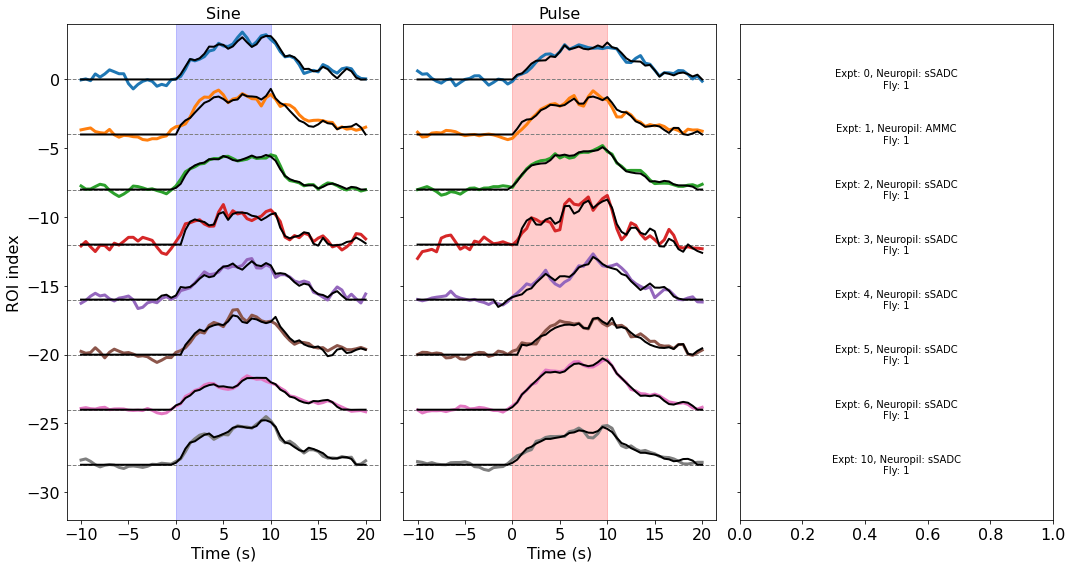

In [14]:
expt_ids_plot = [0, 1, 2, 3, 4, 5, 6, 10]
nroi_plot = len(expt_ids_plot)
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    neuropil = row_s['NEUROPIL']
    fly = row_s['FLY']
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, Neuropil: {neuropil}\nFly: {fly}', ha='center', va='center')
    
    # prediction
    ## sine response
    row_s = df_pred_lin[(df_pred_lin['EXPT_ID'] == expt_id) & (df_pred_lin['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_lin[(df_pred_lin['EXPT_ID'] == expt_id) & (df_pred_lin['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs, ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)

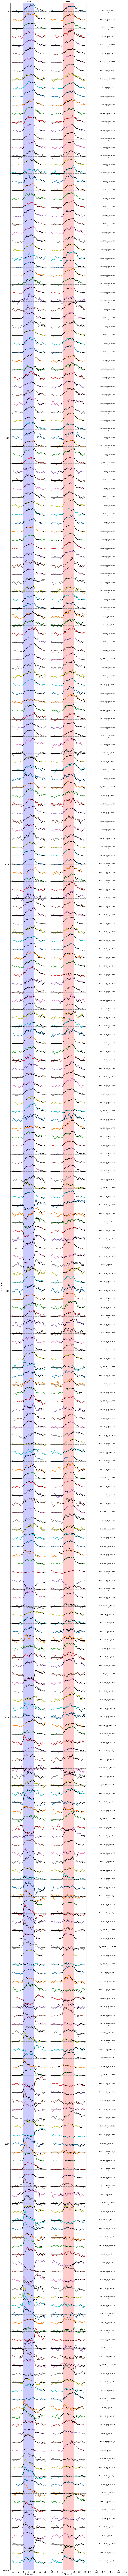

In [13]:
expt_ids_plot = range(300)
nroi_plot = len(expt_ids_plot)
t = np.arange(NT)*DT - 10

fig, axs = plt.subplots(1, 3, figsize=(15, nroi_plot), sharey=True,  tight_layout=True)
for cexpt, expt_id in enumerate(expt_ids_plot):
    # true response
    ## sine response
    row_s = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    neuropil = row_s['NEUROPIL']
    fly = row_s['FLY']
    
    axs[0].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[0].plot(T, rsp_s - 4*cexpt, lw=3)
    
    ## pulse response
    row_p = df[(df['EXPT_ID'] == expt_id) & (df['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].axhline(-4*cexpt, lw=1, ls='--', c='gray')
    axs[1].plot(T, rsp_p - 4*cexpt, lw=3)
    
    axs[2].text(0.5, -4*cexpt, f'Expt: {expt_id}, Neuropil: {neuropil}\nFly: {fly}', ha='center', va='center')
    
    # prediction
    ## sine response
    row_s = df_pred_lin[(df_pred_lin['EXPT_ID'] == expt_id) & (df_pred_lin['STIM'] == 'S')].iloc[0]
    rsp_s = np.array(row_s).flatten()[6:]
    
    axs[0].plot(T, rsp_s - 4*cexpt, lw=2, c='k')
    
    ## pulse response
    row_p = df_pred_lin[(df_pred_lin['EXPT_ID'] == expt_id) & (df_pred_lin['STIM'] == 'P')].iloc[0]
    rsp_p = np.array(row_p).flatten()[6:]
    
    axs[1].plot(T, rsp_p - 4*cexpt, lw=2, c='k')
    
    
axs[0].set_ylabel('ROI index')

for ax, c, stim in zip(axs, ['b', 'r'], ['Sine', 'Pulse']):
    ax.axvspan(T[IT_STIM[0]], T[IT_STIM[1]], color=c, alpha=.2)
    ax.set_title(stim)
    ax.set_ylim(-4*nroi_plot, 4)
    ax.set_xlabel('Time (s)')
    
set_font_size(axs, 16)